In [1]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [2]:
%autosave 0
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from functools import partial

Autosave disabled


# Python y  Rendimiento | Parte 1

Python es un lenguaje interpretado de alto nivel que es muy conveniente para prototipar y hacer análisis 
exploratorio

Esto tiene un costo: Menor **rendimiento** a igual **complejidad** en comparación a lenguajes compilados de bajo nivel

Podemos ser más específicos y hablar de **eficiencia**:

> Temporal: Tiempo para completar una tarea (tiempo en la CPU)

> Espacial: Utilización de espacio (memoria RAM, disco)

Ambos son factores críticos en algunas aplicaciones (big-data)

Existe entonces una necesidad por mejorar el rendimiento de nuestro código

> A esto lo llamamos **Optimización** de código

En la siguiente clase veremos distintas formas de **optimizar** código escrito en Python

Sin embargo antes de optimizar es necesario diagnosticar e identificar los sectores críticos (cuellos de botella) de nuestro programa

> Esto lo llamamos *Profiling* de código


# *Profiling*

Se refiere a medir los 

1. Tiempos de ejecución (total, por función, por linea)
1. Uso de recursos (memoria, cpu, disco)

de una rutina con el fin de encontrar aquellas secciones más lentas e ineficientes (sectores críticos)

Luego de identificarlas podemos reescribirlas u optimizarlas

En esta clase veremos como hacer un *profiling* de nuestro código en Python usando el ambiente *Jupyter* y las magias de *IPython*

### Ejemplo: Set de Julia

El [set de Julia](https://en.wikipedia.org/wiki/Julia_set) es un fractal asociado a la función

$$
f(z) = z^2 + c,
$$
donde $c \in \mathbb{C}$

El script [fractal.py](./fractal.py) tiene una implementación del set de Julia usando Python puro (sin librerias)

Si ejecutamos la función `make_fractal.py` con una resolución de 500 pixeles y 50 iteraciones el resultado es

<IPython.core.display.Javascript object>


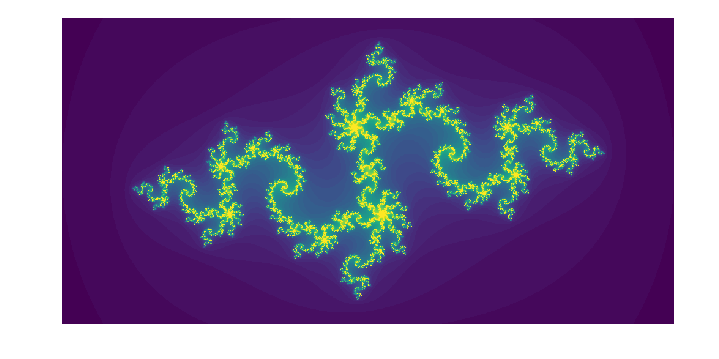

In [3]:
from fractal import make_fractal, evaluate_z
fractal_image = make_fractal(N=500, maxiters=50)

fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
ax.imshow(fractal_image, aspect='equal', cmap=plt.cm.viridis, origin='lower')
ax.axis('off');

Usaremos partial para fijar los parámetros de `make_fractal`

A continuación haremos un *profiling* de `slow_function`

In [5]:
slow_function = partial(make_fractal, N=500, maxiters=50)

## Tiempo de ejecución con magias de IPython

Podemos medir el tiempo total de un bloque de ejecución completo con la magia `%%time`

¿Cuánto demora en calcularse el set de julia?

In [6]:
%%time 
result = slow_function()

CPU times: user 3.07 s, sys: 6.06 ms, total: 3.07 s
Wall time: 3.08 s


En mi computador (Core i5-4200U, 1.6 Ghz) demora 1.88s

¿Cuánto demora en el tuyo? ¿Cómo se compara tu CPU con el mio?

También podemos medir el tiempo de una linea en particular con la magia `%time`

Por ejemplo:

In [7]:
%time result1 = slow_function()
%time result2 = slow_function()
%time result3 = slow_function()
%time result4 = slow_function()
# Son los resultados iguales?
np.allclose(result1, result2)

CPU times: user 3.04 s, sys: 286 µs, total: 3.04 s
Wall time: 3.05 s
CPU times: user 3.02 s, sys: 75 µs, total: 3.02 s
Wall time: 3.03 s
CPU times: user 3.09 s, sys: 3.25 ms, total: 3.09 s
Wall time: 3.11 s
CPU times: user 3.11 s, sys: 15.9 ms, total: 3.13 s
Wall time: 3.15 s


True

A pesar de ejecutar el mismo código y obtener el mismo resultado los tiempos de cómputo son ligeramente distintos ¿Por qué?

> Cada vez que ejecutamos un código alteramos el estado de nuestro sistema (cache, memoria)

La magia `%timeit -rX -nY` ejecuta nuestro código X veces y retorna el tiempo promedio y la desviación estándar. Por cada ejecución se guarda el mejor tiempo de Y repeticiones

El tiempo para 10 repeticiones del set de julia es:

In [8]:
%timeit -r10 -n1 result = slow_function()

3.1 s ± 67.6 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


Esta magia se basa en el módulo de Python [timeit](https://docs.python.org/3/library/timeit.html)

**OJO:** Los tiempos de `timeit` suelen ser menores a los de `time`. Es porque `timeit` omite las tareas de *garbage collection*

Podemos activar *gc* usando el módulo de forma directa:

    import timeit
    timeit.timeit(slow_function, 'gc.enable()', number=10)/10

### Midiendo el tiempo de cada función con cProfile

El módulo de Python [cProfile](https://docs.python.org/3/library/profile.html) mide la cantidad de llamadas y el tiempo de cada función ejecutada por nuestra rutina

El resultado es una tabla con las siguientes filas

- ncalls: Número de veces que se llama la función
- tottime: Tiempo total en dicha función (sin contar subfunciones)
- percall: ttime/ncalls
- cumtime: Tiempo total en dicha función y sus subfunciones (tiempo de función recursiva)
- percall: cumtime/ncalls

La magia de IPython `%prun` nos da una forma conveniente para usar este módulo

In [9]:
%prun slow_function()

De la tabla vemos que 
- La función con mayor tiempo total es `evaluate_z` que está en la linea 1 de fractal.py
- `evaluate_z()` se llama 500.000 veces

En general el tiempo total es mayor que el que medimos con `time` y `timeit`: Esto corresponde al overhead de `prun`

Opciones importantes de `prun`
- `-s` para que el resultado quede ordenado según una fila en particular 
- `-l` si queremos especificar la cantidad de líneas a mostrar

In [10]:
%prun -s cumtime slow_function()

También podemos usar `%%prun` para hacer *profiling* de un bloque completo

In [11]:
%%prun -l 5 -s cumtime 

data = np.random.randn(100000)
hist, edges = np.histogram(data)

y si no contamos con el ambiente IPython podemos usar cProfile directamente sobre un script de Python con

        python -m cProfile -o tabla.prof script.py
        
Donde el resultado queda grabado en el archivo tabla.prof

#### Visualizando con snakeviz

Podemos generar una visualización de los resultados de `cProfile` en nuestro navegador usando [`SnakeViz`](https://jiffyclub.github.io/snakeviz/)

Primero lo instalamos con [conda](https://anaconda.org/conda-forge/snakeviz) o con

    pip3 install snakeviz
    
Esto creará un ejecutable snakeviz en `/usr/bin`

Luego cargamos la extensión para jupyter:

In [12]:
%load_ext snakeviz

Y ahora podemos usar las magias `%snakeviz` para una rutina y `%%snakeviz` para un bloque completo

La opción `-t` carga el gráfico en una pestaña de navegador nueva

In [13]:
%snakeviz -t slow_function()

 
*** Profile stats marshalled to file '/tmp/tmponw519ll'. 
Opening SnakeViz in a new tab...


Esta herramiento puede mejorar considerablemente el estudio de nuestro código cuando se tiene una gran cantidad de funciones en distintas jerarquías

### Midiendo el tiempo de cada linea

A veces puede ser más informativo medir el tiempo linea a linea en lugar de función a función

Podemos lograr esto último usando la extensión [`line_profiler`](https://github.com/rkern/line_profiler). 

Luego de instalar y habilitarla tendremos a disposición la magia `%lprun` que funciona de forma similar a `prun`

***
Se recomienda instalar con conda: https://anaconda.org/anaconda/line_profiler

Si no usas conda puedes instalar manualmente con

    git clone https://github.com/rkern/line_profiler.git
    find line_profiler -name '*.pyx' -exec cython {} \;
    cd line_profiler && pip3 install . --user 
    
La instalación con PIP no funciona de momento (ver repositorio de line_profiler)
***

In [1]:
%load_ext line_profiler

La magia requiere que se especifique un método/función dentro de la rutina

In [ ]:
%lprun -f make_fractal slow_function()

Casi el 90% del tiempo se ocupa en la linea 20 , la función `evaluate_z`

Podemos hacer run profiling de dicha función

In [ ]:
%lprun -f evaluate_z slow_function()

## Uso de memoria con magias de IPython

Podemos descargar y habilitar la extensión `memory_profiler` para medir la cantidad de memoria usada por nuestra rutina

    pip3 install memory_profiler --user


In [15]:
%load_ext memory_profiler

ModuleNotFoundError: No module named 'memory_profiler'

Podemos usar `%memit` para medir la memoria total

In [ ]:
%memit slow_function()

y `%mprun` para medir el uso de memoria linea por linea

**OJO:** `mprun` requiere que la función esté escrita en un archivo `.py` (en este caso está en fractal.py)

    %mprun -f make_fractal make_fractal(N=50, maxiter=1)

## Uso de memoria con `trace`

Próxima iteración

Brett Slatkin, Effective Python

In [ ]:
import tracemalloc